In [113]:
import pandas as pd, os, numpy as np, random as r, pickle, math
from matplotlib import pyplot as plt

# Things to consider:
   # Should I store viable middles and edges?
      # YES: DONE – SEE ./MERGE_SAFETY

# WRITTEN #
   # Pick the four mechanisms and if they will be cathodic – scaling factor auto-assigned
   # Assign a file to the mechanism – CURRENTLY DUMMY FILES
   # Calculate merge points
      # Calculate fractional peak currents
      # Select representative scan rate to dictate the merge points
      # Calculate peak ratio and reversibility
   # Scale and flip mechanisms
   # Randomly select merge point from [min(merge_point), min(merge_point)+1000mV]
   # If change in current over first and last 100mV is less than 0.05, it can be merged from that side
   # This could be a consideration when selecting files 
   # If the switching potential is before diffusion limited current is reached, the current cant't 
      # reasonably be extrapolated – that datatset could be labelled as a terminal candidate, though

def plot(df, save=False, name=None):
   for v in df['v'].unique():
      t = df.loc[df['v'] == v].copy()
      if 'newA' in t.columns:
         plt.scatter(t['V'], t['A'], s=0.1)
      else:
         plt.scatter(t['V'], t['A'], s=0.1)
   if save:
      plt.savefig(f'./Graphs/{name}', dpi=200)
   plt.show()
   plt.clf()

class Mech:
   def __init__(self, mech, cathodic):
      self.mech = mech
      self.cathodic = cathodic
      self.data = None
      self.file = None
      self.scaling = r.randint(50, 100)/100

   def __str__(self):
      return f'Mech: {self.mech}, Cathodic: {self.cathodic}, Scaling: {self.scaling}, File: {self.file}'

# Step zero, label each available file as either mergeable, half-mergeable, or not mergeable

# Step one – pick the four mechanisms (NO ERRORS)
def get_mechs():
   mechs = [None]*4
   x = r.randint(1, 8)
   if x == 1:
      cath = round(r.random())
      if cath:
         mechs[0] = Mech("T", True)
      else:
         mechs[-1] = Mech("T", False)

   x = r.randint(1, 8)
   if x == 2:
      cath = round(r.random())
      if cath and not mechs[0]:
         mechs[0] = Mech("ECP", True)
      elif cath:
         mechs[-1] = Mech("ECP", False)
      elif mechs[-1]:
         mechs[0] = Mech("ECP", True)
      else:
         mechs[-1] = Mech("ECP", False)

   # EC1 is equal to EC anodic or CE cathodic, EC2 is equal to CE anodic or EC cathodic
   remaining_mechs = ["E", "EC1", "ECE", "DISP", "CE"] # REMOVED SR
   for i, spot in enumerate(mechs):
      if not spot:
         x = r.randint(0, 4)
         cathodic = True if round(r.random()) == 1 else False
         mechs[i] = Mech(remaining_mechs[x], cathodic)
   
   return mechs

In [2]:
# Step two – select files (NO ERRORS)
def get_files(mechs):
   for i, mech in enumerate(mechs):
      # safe means it can be merged from either side, so no special consideration is necessary
      safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_safe.pkl', 'rb'))
      # half safe means it is useable as a beginning or terminal mechanism so needs to be looked at
      half_safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_half_safe.pkl', 'rb'))
      if i == 1 or i == 2:
         file = r.choice(list(safe.keys()))
      # considerations on if T or ECP need to be flipped have already been made so pick any file
      elif mech.mech == 'T' or mech.mech == 'ECP':
         options = list(safe.keys())
         options.extend(list(half_safe.keys()))
         file = r.choice(options)
      else:
         options = list(safe.keys())
         options.extend(list(half_safe.keys()))
         file = r.choice(options)
         if file not in safe:
            # if data is only mergeable from one side, we may need to over-ride the assigned flipping
            left_safe = half_safe[file][0]
            right_safe = half_safe[file][1]
            if left_safe: # must be flipped if it is left most, otherwise can't be
               if i == 0:
                  mech.cathodic = True
               else:
                  mech.cathodic = False
            else: # must be flipped if it right most, otherwise can't be
               if i == 0:
                  mech.cathodic = False
               else:
                  mech.cathodic = True
      mech.file = file
      mech.data = pd.read_csv(f'./Samples/{mech.mech}/{file}')
      min_V = min(mech.data['V'])
      mech.data['V'] = mech.data.loc[:,'V'].apply(lambda x : x-min_V)
      mech.data.reset_index(inplace=True, drop=True)

In [114]:
# Step three – adjust data by scaling and reversing if cathodic
def adjust_data(mech):
   flip = -1 if mech.cathodic else 1
   mech.data['A'] = mech.data.loc[:,'A'].apply(lambda x : x*flip*mech.scaling)
   res = pd.DataFrame()
   if mech.cathodic:
      for v in mech.data['v'].unique():
         t = mech.data.loc[mech.data['v'] == v].copy()
         currents = t.loc[:,'A']
         n = len(currents)//2
         fwd_currents = list(currents[:n])
         rev_currents = list(currents[n:])
         rev_currents.extend(fwd_currents)
         t['A'] = rev_currents
         res = pd.concat([res, t])
      mech.data = res
   mech.data.reset_index(inplace=True, drop=True)

In [115]:
# Step four – calculate merge points (not seeing any errors, maybe edge cases to look out for)
def calculate_merge_reps(mech, peak_frac=0.33, sr_rep=0):

   def find_index(l, r, target, data):
      decreasing = data.loc[l, 'A'] > data.loc[r, 'A']
      while (l <= r):
         m = l+(r-l) // 2
         if data.loc[m, 'A'] < target:
            if decreasing:
               r = m-1
            else:
               l = m+1
         else:
            if decreasing:
               l = m+1
            else:
               r = m-1
      return l if l <= data.index[-1] else data.index[-1]

   scan_rates = mech.data['v'].unique()
   rep_data = mech.data[mech.data['v'] == scan_rates[sr_rep]]

   max_A = max(rep_data['A'])
   min_A = min(rep_data['A'])
   
   peak_ratio = abs(min_A/max_A) if abs(min_A) < max_A else abs(max_A/min_A)
   reversible = peak_ratio >= 0.1
   main_peak = max_A if max_A > abs(min_A) else min_A
   # Mpi = max peak index, mpi = min peak index
   Mpi = rep_data[rep_data['A'] == max_A].index[0]
   mpi = rep_data[rep_data['A'] == min_A].index[0]

   merge_points = []
   indices = rep_data.index
   l = indices[0]
   r = indices[-1]
   n = indices[len(indices)//2]
   if rep_data.loc[Mpi, 'A'] == main_peak or reversible:
      target = peak_frac*(max_A-rep_data.loc[n,'A']) + rep_data.loc[n,'A']
      merge_points.append(find_index(l, Mpi, target, rep_data))
      merge_points.append(find_index(Mpi, n, target, rep_data))
   if rep_data.loc[mpi, 'A'] == main_peak or reversible:
      target = rep_data.loc[r,'A'] - peak_frac*(abs(min_A-rep_data.loc[r,'A']))
      merge_points.append(find_index(n+1,mpi, target, rep_data))
      merge_points.append(find_index(mpi, r, target, rep_data))
 
   mech.data['merge_point'] = False
   for point in merge_points:
      mech.data.loc[point, 'merge_point'] = True

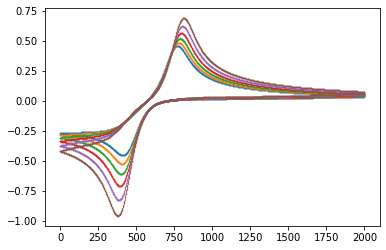

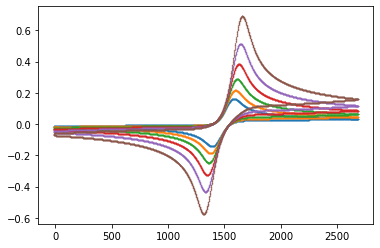

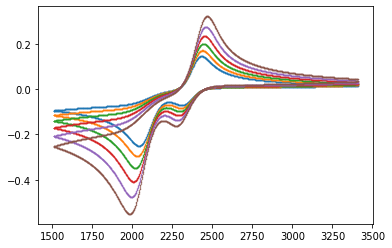

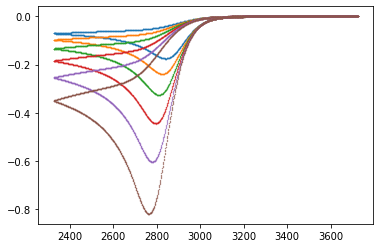

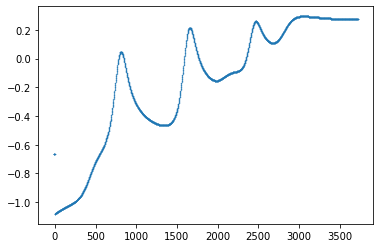

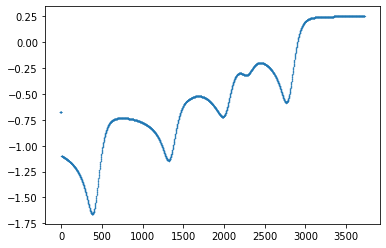

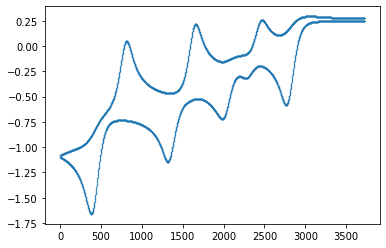

<Figure size 432x288 with 0 Axes>

In [125]:
# Step five – execute merge

# Merge functionality:
   # Calculate merge point = furthest right point on host axis
   # Shift guest data:
      # align left most merge point of guest data to right most of host
      # then, add a random additional shift <= 1000
   # Edge issues:
      # shift of guest data extends beyond the host –> need to fill in
      # guest data extends beyond host in the negative direction
         # this could be an issue of the host data is NOT left mergeable
         # because we can not assume that this data can be extended in -x direction infinitely

# Seems to be working
def __calculate_shifts(mechs, extra_shift_max=200):

   def get_mps(indices, data):
      max_potential = data.loc[indices[0], 'V']
      min_potential = max_potential
      for i in range(1, len(indices)):
         cur = data.loc[indices[i], 'V']
         max_potential = max(max_potential, cur)
         min_potential = min(min_potential, cur)
      return [min_potential, max_potential]

   host = mechs[0].data
   mpis = host.loc[host['merge_point']].index
   host_mps = get_mps(mpis, host)
   shifts = [0]
   for i in range(1, len(mechs)):
      guest = mechs[i].data
      mpis = guest.loc[guest['merge_point']].index
      guest_mps = get_mps(mpis, guest)
      host_pot = host_mps[1]
      guest_pot = guest_mps[0]
      shift = (host_pot-guest_pot) + r.randint(0, extra_shift_max)
      shifts.append(shift)
      guest_mps[1] += shift
      host_mps = guest_mps
   return shifts

def __addcurs(x, y):
      if math.isnan(x):
         x = 0
      if math.isnan(y):
         y = 0
      return x + y

def __merge_dfs(dfs, rev=False):
   
   res = pd.DataFrame()
   to_add_right = 0
   right_cutoff = 0
   for df in dfs:
      if rev:
         df = df[::-1]
      if len(res) == 0:
         res = df
         to_add_right = df.loc[df.index[-1], 'A'] 
         right_cutoff = max(df['V'])
      else:
         to_add_left = df.loc[df.index[0], 'A']
         left_cutoff = min(df['V'])
         df['A'] = df.apply(lambda x: x['A'] + to_add_right if x['V'] > right_cutoff else x['A'], axis=1)
         right_cutoff = max(df['V'])
         to_add_right = df.loc[df.index[-1], 'A'] 
         res = res.merge(df, how='outer', left_on=['V','v'], right_on=['V','v'])
         res['A'] = res.apply(lambda x: __addcurs(x['A_x'], x['A_y']), axis=1)
         res.drop(['A_x', 'A_y'], axis=1, inplace=True)
         res['A'] = res.apply(lambda x: x['A'] + to_add_left if x['V'] < left_cutoff else x['A'], axis=1) 
      res.reset_index(inplace=True, drop=True)
   plot(res)
   return res


for i in range(1):

   # obtain data and get merge points
   mechs = get_mechs()
   get_files(mechs)
   for i, mech in enumerate(mechs):
      adjust_data(mech)
      calculate_merge_reps(mech)
   
   # shift data, remap scan rates, 
   shifts = __calculate_shifts(mechs)
   for i, mech in enumerate(mechs):
      mech.data['V'] = mech.data['V'].apply(lambda x: x+shifts[i])
      mapping = {}
      for i,v in enumerate(mech.data['v'].unique()):
         mapping[v] = i
      mech.data.replace({'v': mapping}, inplace=True)
      mech.data.drop(['merge_point'], axis=1, inplace=True)
   
   # merging
   for i in range(6):
      fwd_dfs = []
      rev_dfs = []
      name = ""
      global_max = 0
      for j, mech in enumerate(mechs):
         if j == 3:
            global_max = max(mech.data['V'])
         plot(mech.data)
         name += mech.file[:-4]
         data = mech.data[mech.data['v'] == 6-i-1].copy()
         n = len(data)//2
         fwd_dfs.append(data.iloc[:n, :].copy())
         rev_dfs.append(data.iloc[n:, :].copy())
      fwd_full = __merge_dfs(fwd_dfs)
      rev_full = __merge_dfs(rev_dfs, rev=True)
      res = pd.concat([fwd_full, rev_full])
      res = res.loc[(res['V'] > 0) & (res['V'] < global_max)]
      plot(res, save=True, name=name)
      break
      



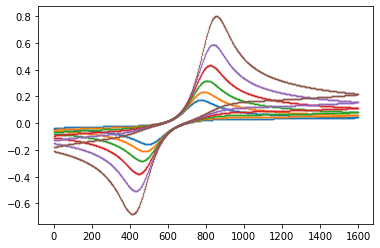

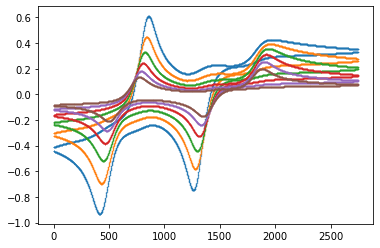

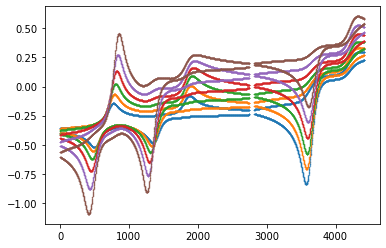

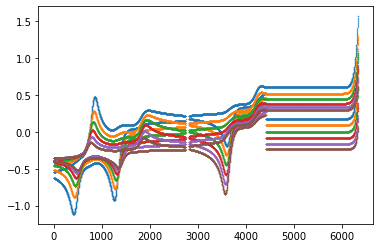

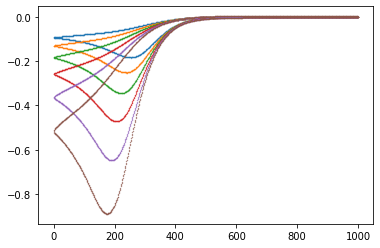

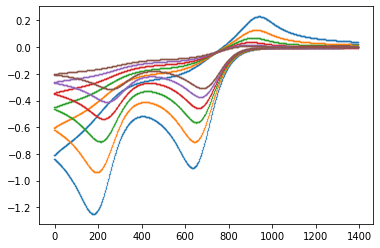

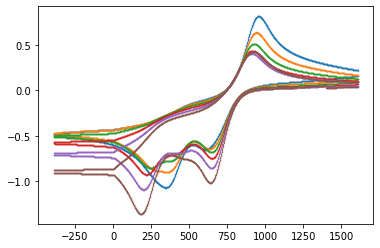

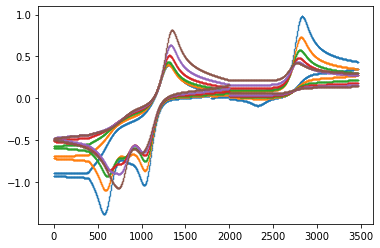

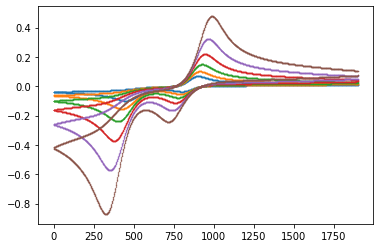

KeyError: 22631

<Figure size 432x288 with 0 Axes>

In [8]:
# Helper function to merge_data
def __merge(host, guest, fwd):

   def add(v, x, y):
      nonlocal fwd
      nonlocal host
      nonlocal guest
      # When merging datasets, sometimes a potential (v)
      # is only present in one, in that case, we fill in either
      # the extrapolated diffusion limited current or the background
      # current
      if fwd:
         if v < min(host['V']):
            x = host.loc[host.index[0],'A']
         if v > max(host['V']):
            x = host.loc[host.index[-1],'A']
         if v < min(guest['V']):
            y = guest.loc[guest.index[0],'A']
         if v > max(guest['V']):
            y = guest.loc[guest.index[-1],'A']
      else:
         if v < min(host['V']):
            x = host.loc[host.index[-1],'A']
         if v > max(host['V']):
            x = host.loc[host.index[0],'A']
         if v < min(guest['V']):
            y = guest.loc[guest.index[-1],'A']
         if v > max(guest['V']):
            y = guest.loc[guest.index[0],'A']

      return x + y

   df = host.merge(guest, how='outer', left_on=['V'], right_on=['V'])
   df.loc[:, 'A'] = df.apply(lambda x: add(x['V'], x['A_x'], x['A_y']), axis=1)
   return df
   
# Step five, iteratively merge
def merge_data(host, guest, srs):
   # shift guest data relative to host data pre-merge
   min_V = min(host['V'])
   host['V'] = host.loc[:,'V'].apply(lambda x: x-min_V)
   #mp_host = host.loc[host['merge_point'] == True].index[-1]
   host_mps = host.loc[host['merge_point'] == True].index
   mp_host = None
   for ind in host_mps:
      if not mp_host:
         mp_host = ind
      else:
         mp_host = mp_host if host.loc[mp_host, 'V'] > host.loc[ind, 'V'] else ind
   host_mp_V = host.loc[mp_host, 'V']
   guest_guestmps = guest.loc[guest['merge_point'] == True].index
   mp_guest = None
   for ind in host_mps:
      if not mp_guest:
         mp_guest = ind
      else:
         mp_guest = mp_guest if host.loc[mp_guest, 'V'] < host.loc[ind, 'V'] else ind
   guest_mp_V = guest.loc[mp_guest, 'V']
   shift = guest_mp_V - host_mp_V
   rand_plus = r.randint(0, 500)
   guest['V'] = guest.loc[:,'V'].apply(lambda x: (x-shift)+rand_plus)
   #merge the guest and host
   merged = pd.DataFrame()
   srs_host = host['v'].unique()
   srs_guest = guest['v'].unique()
   srs_fin = []
   prev_length = 0
   for i in range(6):
      t1 = host.loc[host['v'] == srs_host[6-i-1]].copy()
      t2 = guest.loc[guest['v'] == srs_guest[6-i-1]].copy()
      fwdt1 = t1[:len(t1)//2]
      fwdt2 = t2[:len(t2)//2]
      revt1 = t1[len(t1)//2:]
      revt2 = t2[len(t2)//2:]
      merged = pd.concat([merged, __merge(fwdt1, fwdt2, True)])
      merged = pd.concat([merged, __merge(revt1, revt2, False)])
      merged = merged[['V', 'A', 'merge_point_x', 'merge_point_y']]
      cur_sr = [srs[6-i-1]]*(len(merged)-prev_length)
      srs_fin.extend(cur_sr)
      prev_length = len(merged)
   merged['v'] = srs_fin
   merged['merge_point'] = merged.apply(lambda x : True if x['merge_point_y'] == True else False, axis=1)
   merged.drop(['merge_point_x', 'merge_point_y'], axis=1, inplace=True)
   return merged

for i in range(5):
   mechs = get_mechs()
   get_files(mechs)
   for i, mech in enumerate(mechs):
      adjust_data(mech)
      calculate_merge_reps(mech)
      #mps = mech.data[mech.data['merge_point'] == True].index
      #mpstring = ""
      #for mp in mps:
      #   mpstring += "(" + str(mp) + ", " + str(round(mech.data.loc[mp, 'V'],3)) + ", " + str(round(mech.data.loc[mp, 'A'],3)) + ")"
      #print(mech)
      #print(mpstring)
      #plot(mech.data)
   host = pd.DataFrame()
   srs = None
   files = ""
   for mech in mechs:
      files += mech.file[:-4]
      mech.data.reset_index(inplace=True, drop=True)
      if len(host) == 0:
         host = mech.data
         srs = host['v'].unique()
      else:
         host = merge_data(host, mech.data, srs)
      host.reset_index(inplace=True, drop=True)
      plot(host)
   plt.savefig(f'{files}.png', dpi=200)
      # for i, mech in enumerate(mechs):
   #    print(mech)
   #    if i > 0:
   #       print(left_adtnl_currents[5].pop(0)) 
   #    if i < 3:
   #       print(right_adtnl_currents[5].pop(0))
   #    plot(mech.data)

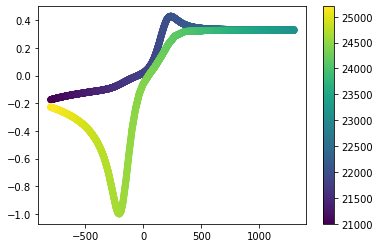

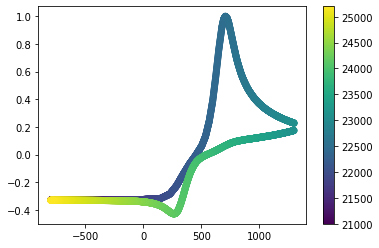

,V,A,v
21000,-799.0,-0.326731,2.0
21001,-798.0,-0.326767,2.0
21002,-797.0,-0.326803,2.0
21003,-796.0,-0.326801,2.0
21004,-795.0,-0.326799,2.0
...,...,...,...
25195,-796.0,-0.329585,2.0
25196,-797.0,-0.329583,2.0
25197,-798.0,-0.329581,2.0
25198,-799.0,-0.329579,2.0


<Figure size 432x288 with 0 Axes>

In [33]:
f = pd.read_csv('./Samples/CE/CE_1580.txt')
f = f.loc[f['v'] == max(f['v'])]
plt.scatter(f['V'], f['A'], c=f.index)
plt.colorbar()
plt.show()
plt.clf()
n = len(f)//2
currents = f.loc[:,'A']
fwd_currents = list(currents[:n])
rev_currents = list(currents[n:])
rev_currents.extend(fwd_currents)
f['A'] = rev_currents
f['A'] = f.apply(lambda x: -1*x['A'], axis=1)
plt.scatter(f['V'], f['A'], c=f.index)
plt.colorbar()
plt.show()
plt.clf()
f
